# California "Conservation-Consumption Score" analysis

By Ryan Menezes, Matt Stevens and Ben Welsh

[A Los Angeles Times analysis published on Oct. 31, 2016](http://www.latimes.com/local/lanow/la-me-ln-water-conservation-backslide-20161018-snap-htmlstory.html), found that the overwhelming majority of California water districts increased their usage after the state eased its drought restrictions. Some of the most extreme increases were found in inland Northern California, led by the San Juan Water District near Folsom Lake.

How did The Times come to that conclusion? Using the computer code that follows.

**Here's how it worked.**

We started by downloading data from California’s State Water Resources Control Board, which publishes a monthly accounting of each district’s water usage on its website.

That data has been used by state regulators to monitor and enforce mandatory water-use reductions introduced as part of the state’s emergency drought response. Regulators ended mandatory conservation for the vast majority of urban water suppliers this spring.

The state measures each district’s water savings by comparing the number of gallons it supplies to homes, businesses and institutions each month versus the same month in 2013, a baseline that precedes Gov. Jerry Brown’s proclamation of a drought State of Emergency.

The code below calculates that statistic for three months this summer after restrictions were eased, then compares it against the same months in 2015. In total, 93% of 387 districts increased water usage this year. Nineteen districts were excluded because they did not report enough data to the state.

California’s water districts vary greatly in size, from large urban areas like Los Angeles to small districts in the rural north. To compare suppliers and identify areas where residents use large amounts of water at home, state officials also track the total amount of water used by each district’s average resident each day.

This code combines that measure with each district’s change in total summer water usage to create a ranking we’re calling a Conservation-Consumption Score. By including both factors, this statistic -- sometimes known as a z-score -- better identifies areas where residents account for increases.

Some of the highest ranking districts by this score were found in Northern California and around Folsom Lake near Sacramento. The top score belonged to the San Juan Water District, the ultimate focus of our story.

##### Import and configure analysis tools.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from __future__ import division
%matplotlib inline

In [2]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option("display.max_columns", 500)

##### Import raw water usage data from the state 

In [3]:
supplier_path = os.path.join(os.getcwd(), 'uw_supplier_data100516.xlsx')

In [4]:
SUPPLIER_TABLE = pd.read_excel(supplier_path)

##### Keep the columns we want

In [5]:
supplier_table = SUPPLIER_TABLE.iloc[:,[0,3,18,19,21]]

In [6]:
supplier_table.columns = [
    'supplier_name',
    'month',
    'total_water_production_gallons',
    'total_water_production_gallons_2013',
    'residential_water_usage'
]

##### Clean them up

In [7]:
supplier_table['month'] = supplier_table['month'].astype(str)

/home/ben/.virtualenvs/ca-water-conservation-analysis/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [8]:
supplier_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10936 entries, 0 to 10935
Data columns (total 5 columns):
supplier_name                          10936 non-null object
month                                  10936 non-null object
total_water_production_gallons         10936 non-null float64
total_water_production_gallons_2013    10936 non-null float64
residential_water_usage                10936 non-null float64
dtypes: float64(3), object(2)
memory usage: 427.3+ KB


In [9]:
supplier_table.head()

,supplier_name,month,total_water_production_gallons,total_water_production_gallons_2013,residential_water_usage
0,East Bay Municipal Utilities District,2016-08-15,6007500000.00,7172300000.00,84.44
1,East Bay Municipal Utilities District,2016-07-15,6056600000.00,7452200000.00,83.73
2,East Bay Municipal Utilities District,2016-06-15,5675900000.00,6927500000.00,82.44
3,East Bay Municipal Utilities District,2016-05-15,4959300000.00,6716500000.00,68.56
4,East Bay Municipal Utilities District,2016-04-15,4018800000.00,5417500000.00,59.33


##### Filter the data to only the three summer months in 2015 and 2016 

In [10]:
target_months = ['2016-08-15', '2016-07-15', '2016-06-15', '2015-08-15', '2015-07-15', '2015-06-15',]
month_table = supplier_table[supplier_table['month'].isin(target_months)]

In [11]:
month_table.drop_duplicates(inplace=True)

/home/ben/.virtualenvs/ca-water-conservation-analysis/local/lib/python2.7/site-packages/pandas/util/decorators.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return func(*args, **kwargs)


In [12]:
"Total records: {}".format(len(supplier_table))

'Total records: 10936'

In [13]:
"Month records: {}".format(len(month_table))

'Month records: 2425'

##### Eliminate any suppliers who have fewer or greater than six months of data with those labels 

In [14]:
supplier_counts = month_table.groupby("supplier_name")['supplier_name'].count().to_frame("count").reset_index()

In [15]:
incomplete_month_table = supplier_counts[supplier_counts['count'] <> 6]

In [16]:
incomplete_month_table

,supplier_name,count
7,"Anderson, City of",5
34,Calexico City of,5
118,Escondido City of,5
167,Hi-Desert Water District,5
195,Lemoore City of,4
200,Livingston City of,5
210,Lynwood City of,5
225,Mission Springs Water District,5
227,Monrovia City of,4
280,Porterville City of,4


In [17]:
complete_month_table = month_table[~month_table['supplier_name'].isin(incomplete_month_table['supplier_name'])]

In [18]:
"Complete month records: {}".format(len(complete_month_table))

'Complete month records: 2334'

##### Group and sum the total water production for each summer 

In [19]:
summer_16_table = complete_month_table[complete_month_table['month'].isin(['2016-08-15', '2016-07-15', '2016-06-15',])]

In [20]:
summer_16_totals = summer_16_table.groupby("supplier_name")['total_water_production_gallons'].sum().to_frame("total_water_production_16").reset_index()

In [21]:
summer_16_totals.head(5)

,supplier_name,total_water_production_16
0,Adelanto City of,434024228.54
1,Alameda County Water District,3937000000.00
2,Alco Water Service,344299000.00
3,Alhambra City of,775637185.75
4,Amador Water Agency,350910000.00


In [22]:
"Summer 16 records: {}".format(len(summer_16_totals))

'Summer 16 records: 389'

In [23]:
summer_15_table = complete_month_table[complete_month_table['month'].isin(['2015-08-15', '2015-07-15', '2015-06-15',])]

In [24]:
summer_15_totals = summer_15_table.groupby("supplier_name")['total_water_production_gallons'].sum().to_frame("total_water_production_15").reset_index()

In [25]:
summer_15_totals.head(5)

,supplier_name,total_water_production_15
0,Adelanto City of,387316100.00
1,Alameda County Water District,3374000000.00
2,Alco Water Service,350899000.00
3,Alhambra City of,777996350.08
4,Amador Water Agency,287480000.00


In [26]:
"Summer 15 records: {}".format(len(summer_15_totals))

'Summer 15 records: 389'

In [27]:
summer_13_totals = summer_16_table.groupby("supplier_name")['total_water_production_gallons_2013'].sum().to_frame("total_water_production_13").reset_index()

In [28]:
summer_13_totals.head()

,supplier_name,total_water_production_13
0,Adelanto City of,393342171.40
1,Alameda County Water District,5273000000.00
2,Alco Water Service,447983000.00
3,Alhambra City of,1060724599.23
4,Amador Water Agency,431220000.00


In [29]:
"Summer 13 records: {}".format(len(summer_13_totals))

'Summer 13 records: 389'

##### Join those summer production totals into a combined table

In [30]:
summer_table = summer_16_totals.merge(summer_15_totals, on="supplier_name")
summer_table = summer_table.merge(summer_13_totals, on="supplier_name")

In [31]:
"Total summer records: {}".format(len(summer_table))

'Total summer records: 389'

In [32]:
summer_table.head(5)

,supplier_name,total_water_production_16,total_water_production_15,total_water_production_13
0,Adelanto City of,434024228.54,387316100.00,393342171.40
1,Alameda County Water District,3937000000.00,3374000000.00,5273000000.00
2,Alco Water Service,344299000.00,350899000.00,447983000.00
3,Alhambra City of,775637185.75,777996350.08,1060724599.23
4,Amador Water Agency,350910000.00,287480000.00,431220000.00


##### Calculate the percentage change of summers 15 and 16 versus the baseline of summer 2013

In [33]:
summer_table['savings_16'] = summer_table.apply(
    lambda x: (x['total_water_production_16']-x['total_water_production_13'])/float(x['total_water_production_13']),
    axis=1
)

In [34]:
summer_table['savings_15'] = summer_table.apply(
    lambda x: (x['total_water_production_15']-x['total_water_production_13'])/float(x['total_water_production_13']),
    axis=1
)

In [35]:
summer_table.sort_values('savings_16', ascending=False).head()

,supplier_name,total_water_production_16,total_water_production_15,total_water_production_13,savings_16,savings_15
0,Adelanto City of,434024228.54,387316100.00,393342171.40,0.10,-0.02
236,North Marin Water District,1134200000.00,715000000.00,1102000000.00,0.03,-0.35
166,Humboldt Bay Municipal Water District,50810000.00,53060000.00,49765000.00,0.02,0.07
10,Arcata City of,180277000.00,177507000.00,178787000.00,0.01,-0.01
124,Fortuna City of,125000000.00,119100000.00,127100000.00,-0.02,-0.06


##### Calculate the difference between in that statistic between 15 and 16

In [36]:
summer_table['savings_change'] = summer_table.apply(
    lambda x: x['savings_16']-x['savings_15'],
    axis=1
)

In [37]:
summer_table.head(5)

,supplier_name,total_water_production_16,total_water_production_15,total_water_production_13,savings_16,savings_15,savings_change
0,Adelanto City of,434024228.54,387316100.00,393342171.40,0.10,-0.02,0.12
1,Alameda County Water District,3937000000.00,3374000000.00,5273000000.00,-0.25,-0.36,0.11
2,Alco Water Service,344299000.00,350899000.00,447983000.00,-0.23,-0.22,-0.01
3,Alhambra City of,775637185.75,777996350.08,1060724599.23,-0.27,-0.27,-0.00
4,Amador Water Agency,350910000.00,287480000.00,431220000.00,-0.19,-0.33,0.15


##### Rank the cities that have regressed the most towards their 2013 baseline

In [38]:
summer_table.sort_values("savings_change", ascending=False).head()

,supplier_name,total_water_production_16,total_water_production_15,total_water_production_13,savings_16,savings_15,savings_change
236,North Marin Water District,1134200000.00,715000000.00,1102000000.00,0.03,-0.35,0.38
313,San Juan Water District,1783309914.14,1204845426.88,2045265134.82,-0.13,-0.41,0.28
314,San Lorenzo Valley Water District,206498200.00,138808800.00,243345319.00,-0.15,-0.43,0.28
123,Folsom City of,2425963874.01,1835195236.86,2725421335.43,-0.11,-0.33,0.22
321,Santa Fe Irrigation District,1035523249.86,763209212.32,1257134805.37,-0.18,-0.39,0.22


##### Calculate the average monthly water usage per person (R-GPCD) in each district for the summer of 2016

In [39]:
summer_16_means = summer_16_table.groupby('supplier_name')['residential_water_usage'].mean().to_frame("residential_water_usage_mean_16").reset_index()

In [40]:
summer_16_means.head(5)

,supplier_name,residential_water_usage_mean_16
0,Adelanto City of,117.48
1,Alameda County Water District,84.23
2,Alco Water Service,103.25
3,Alhambra City of,89.18
4,Amador Water Agency,102.61


##### Join those water usage average to our combined table

In [41]:
summer_table = summer_table.merge(summer_16_means, on="supplier_name")

In [42]:
summer_table.head(5)

,supplier_name,total_water_production_16,total_water_production_15,total_water_production_13,savings_16,savings_15,savings_change,residential_water_usage_mean_16
0,Adelanto City of,434024228.54,387316100.00,393342171.40,0.10,-0.02,0.12,117.48
1,Alameda County Water District,3937000000.00,3374000000.00,5273000000.00,-0.25,-0.36,0.11,84.23
2,Alco Water Service,344299000.00,350899000.00,447983000.00,-0.23,-0.22,-0.01,103.25
3,Alhambra City of,775637185.75,777996350.08,1060724599.23,-0.27,-0.27,-0.00,89.18
4,Amador Water Agency,350910000.00,287480000.00,431220000.00,-0.19,-0.33,0.15,102.61


##### Calculate summary statistics to judge how many districts regressed in summer 2016

In [43]:
savings_16 = (summer_table.total_water_production_16.sum() - summer_table.total_water_production_13.sum()) / (summer_table.total_water_production_13.sum())
savings_15 = (summer_table.total_water_production_15.sum() - summer_table.total_water_production_13.sum()) / (summer_table.total_water_production_13.sum())

In [44]:
"State water use overall backslid {} percentage points".format((savings_16 - savings_15)*100)

'State water use overall backslid 8.80388151728 percentage points'

In [45]:
pct_backslid = len(summer_table[summer_table['savings_change'] > 0]) / len(summer_table)

In [46]:
"{}% of urban districts in the state backslid".format(pct_backslid*100)

'92.8020565553% of urban districts in the state backslid'

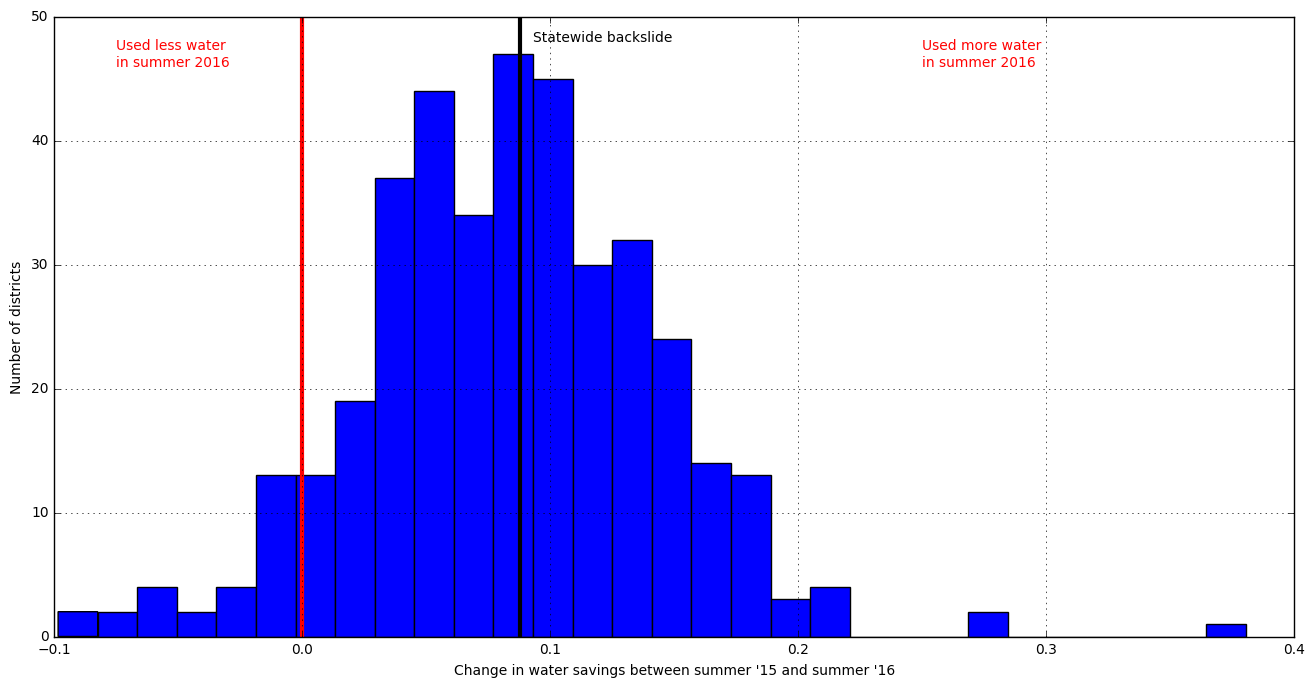

In [47]:
plt.figure(figsize=(16,8))
summer_table.savings_change.hist(bins=30)
plt.axvline(0, linewidth=3, c='red')
plt.axvline(savings_16 - savings_15, c='black', linewidth=3)
plt.annotate("Statewide backslide", (0.093, 48))
plt.annotate("Used less water\nin summer 2016", (-0.075, 46), color='red')
plt.annotate("Used more water\nin summer 2016", (0.25, 46), color='red')
plt.ylabel("Number of districts")
plt.xlabel("Change in water savings between summer '15 and summer '16")

##### Calculate a "Conservation-Consumption Score" that adjusts the savings change by the amount of water usage to surface the high-usage districts that regressed the most 

This indexed score:
1. Accounts for how much a district's savings changed between the summers of 2015 and 2016 (in the numerator)
2. Gives greater weight to districts with high residential water use (RGPCD). Positive scores indicate districts that backslid (in the denominator)

$$
CCS = \frac{SavingsChange}{\frac{1}{\sqrt{RGPCD16}}}
$$

In [48]:
summer_table['cc_score'] = (summer_table['savings_change']) / np.sqrt(1/summer_table['residential_water_usage_mean_16'])

In [54]:
summer_table.sort_values("cc_score", ascending=False).head(10)

,supplier_name,total_water_production_16,total_water_production_15,total_water_production_13,savings_16,savings_15,savings_change,residential_water_usage_mean_16,cc_score
313,San Juan Water District,1783309914.14,1204845426.88,2045265134.82,-0.13,-0.41,0.28,506.73,6.37
236,North Marin Water District,1134200000.00,715000000.00,1102000000.00,0.03,-0.35,0.38,165.57,4.89
321,Santa Fe Irrigation District,1035523249.86,763209212.32,1257134805.37,-0.18,-0.39,0.22,494.66,4.82
20,Bella Vista Water District,1352609273.48,954418829.68,2133349292.57,-0.37,-0.55,0.19,394.38,3.71
123,Folsom City of,2425963874.01,1835195236.86,2725421335.43,-0.11,-0.33,0.22,247.17,3.41
366,Valley Water Company,353353287.44,283979518.63,410344702.02,-0.14,-0.31,0.17,342.44,3.13
314,San Lorenzo Valley Water District,206498200.00,138808800.00,243345319.00,-0.15,-0.43,0.28,114.25,2.97
119,Fair Oaks Water District,1240415368.65,967123776.82,1586443516.01,-0.22,-0.39,0.17,278.96,2.88
367,Vaughn Water Company,1330959198.00,1112734671.00,1596587387.00,-0.17,-0.30,0.14,441.52,2.87
388,Yucaipa Valley Water District,1266950000.00,1029590000.00,1363260000.00,-0.07,-0.24,0.17,262.71,2.82


In [50]:
summer_table.sort_values("cc_score").head(10)

,supplier_name,total_water_production_16,total_water_production_15,total_water_production_13,savings_16,savings_15,savings_change,residential_water_usage_mean_16,cc_score
157,Hanford City of,1320227298.00,1478892470.00,1638207120.00,-0.19,-0.10,-0.10,154.41,-1.20
374,Wasco City of,340340000.00,383540000.00,537330000.00,-0.37,-0.29,-0.08,101.95,-0.81
278,Redlands City of,2373827645.69,2534733080.35,2977565169.64,-0.20,-0.15,-0.05,208.59,-0.78
258,Patterson City of,299352884.00,331531760.00,472549824.00,-0.37,-0.30,-0.07,109.45,-0.71
43,California Water Service Company King City,117795290.86,134772150.21,172538330.60,-0.32,-0.22,-0.10,44.67,-0.66
25,Blythe City of,289600000.00,309500000.00,364000000.00,-0.20,-0.15,-0.05,132.59,-0.63
210,Martinez City of,261478566.22,281485963.62,324474264.91,-0.19,-0.13,-0.06,48.93,-0.43
166,Humboldt Bay Municipal Water District,50810000.00,53060000.00,49765000.00,0.02,0.07,-0.05,88.65,-0.43
235,North Coast County Water District,214788155.83,232613485.70,345158649.33,-0.38,-0.33,-0.05,48.58,-0.36
224,Morro Bay City of,92005424.00,97087596.00,119120801.00,-0.23,-0.18,-0.04,64.21,-0.34


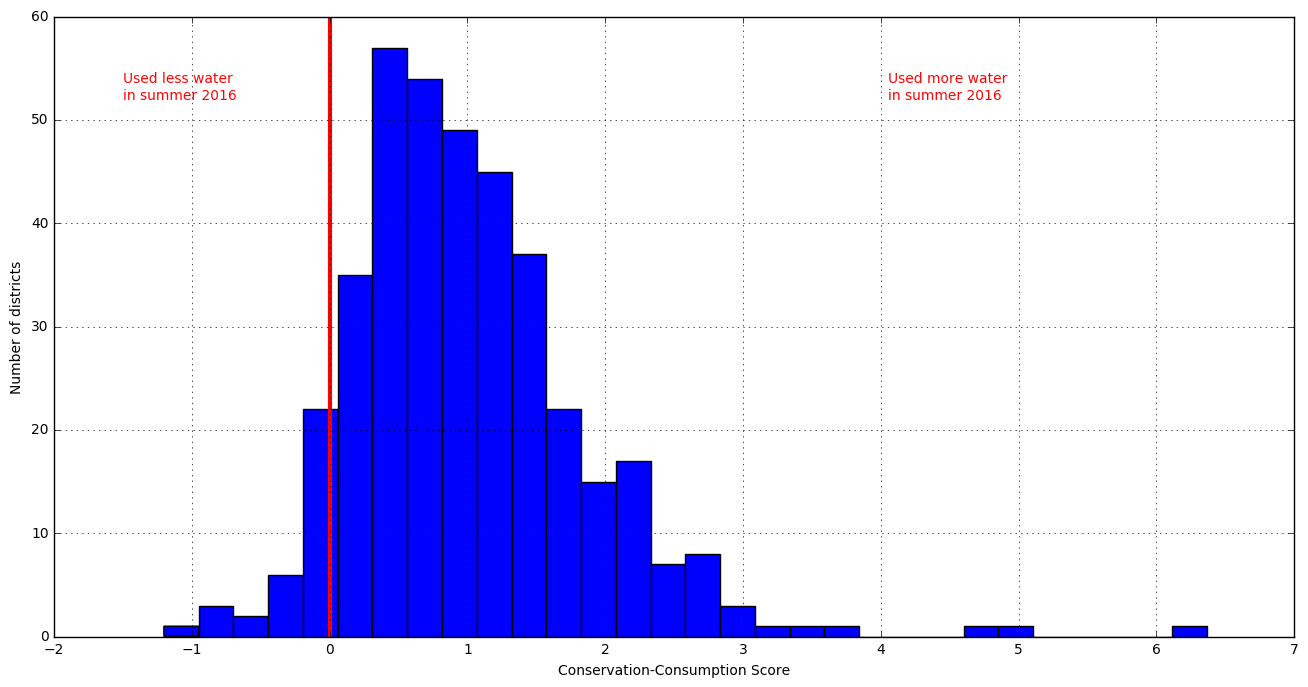

In [51]:
plt.figure(figsize=(16,8))
summer_table.cc_score.hist(bins=30)
plt.axvline(0, linewidth=3, c='red')
plt.annotate("Used less water\nin summer 2016", (-1.5,52), color='red')
plt.annotate("Used more water\nin summer 2016", (4.05,52), color='red')
plt.ylabel("Number of districts")
plt.xlabel("Conservation-Consumption Score")

### Write the combined table out to a CSV 

In [52]:
summer_table.sort_values("cc_score", ascending=False).to_csv("analysis.csv", index=False)